In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kornia.contrib import connected_components
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
from uloss_wmh.loss_functions.neven import *

In [4]:
"""
I need to construct an example.
For that example, I need to construct an example vector map, a seed map
and two instances lets say.

I need a:

[ ] mask
[ ] example vector map
[ ] spatial dims
[ ] 
"""

'\nI need to construct an example.\nFor that example, I need to construct an example vector map, a seed map\nand two instances lets say.\n\nI need a:\n\n[ ] mask\n[ ] example vector map\n[ ] spatial dims\n[ ] \n'

In [5]:
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [7]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=2)

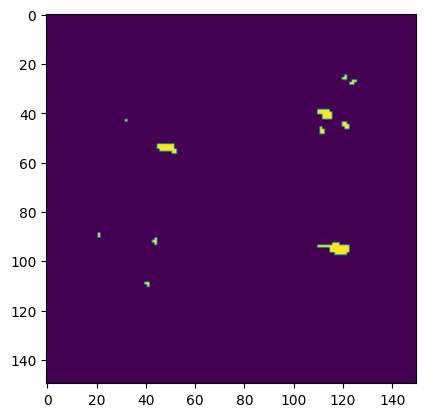

In [8]:
example_label = train_ds[67]['label'][0][25:175, 25:175]
plt.imshow(example_label)

In [9]:
import kornia

In [10]:
ccs = kornia.contrib.connected_components(example_label.unsqueeze(0).unsqueeze(0).type(torch.float32), num_iterations=350)

In [11]:
example_label_instances = ccs

In [24]:
example_label_instances.shape

torch.Size([1, 1, 150, 150])

In [12]:
from monai.losses import DiceLoss

In [257]:
base_loss = DiceLoss(
    sigmoid=False,
    softmax=False,
    reduction='sum',
)

### Testing my implementation of neven

In [258]:
torch.Tensor([1,2]).shape

torch.Size([2])

### Overfitting on the one image

In [388]:
%autoreload

In [389]:
from uloss_wmh.loss_functions.neven_concurrent import *

In [390]:
activ = lambda x : torch.nn.functional.relu(x) + 5e-3#0.005
activ2 = lambda x : torch.sigmoid(x) + 0.001

In [391]:
neven_loss = NevenLoss(
    base_loss = DiceLoss(sigmoid=False,softmax=False, reduction='sum'),
    sigma_normalizer=activ,
    true_spatial_dims=(150,150),
    embedding_spatial_dims=(64, 64, 64),
    embedding_rescale_factor=1/64,
    instance_weight=1,
    seed_weight=1,
    smooth_weight=0.1,
    debug=False
)

In [392]:
neven_loss.embedding_vectors.spatial_dims_to_embedding_dims_factor

tensor([[[0.4267]],

        [[0.4267]],

        [[1.0000]]])

In [393]:
# just define a random input embedding vector
offset_vector_random = torch.randn(1, 3, 150, 150).cuda() * 0.1
sigma_map_random = 0.05 + torch.randn(1,3,150,150).cuda() * 0.01 # + 1 #+ -2.02 #-3.9#torch.randn(1, 2, 150, 150) * 3
seed_map_random = 0.01+ torch.randn(1, 1, 150, 150).cuda() * 0.1

class InputsWrapper(torch.nn.Module):
    def __init__(self, offset_vector_random, sigma_map_random, seed_map_random):
        super().__init__()

        self.offset_vector_random = torch.nn.Parameter(offset_vector_random)
        self.sigma_map_random = torch.nn.Parameter(sigma_map_random)
        # self.log_2pres_squared_random = log_2pres_squared_random
        self.seed_map_random = torch.nn.Parameter(seed_map_random)
        self.instance_distributions = []
        
    def forward(self):
        loss, instance_distributions, (ins, smth, seed) = neven_loss(
            offset_map=self.offset_vector_random,
            # log_2pres_squared=(self.log_2pres_squared_random.tanh() * 2) - 4.6,
            sigma_map=self.sigma_map_random,
            seed_map=self.seed_map_random,
            labels=example_label_instances.cuda(),
        )
        self.instance_distributions.append(instance_distributions)

        return loss, (ins, smth, seed)

In [394]:
model = InputsWrapper(offset_vector_random, sigma_map_random, seed_map_random)

In [395]:
optimizer = torch.optim.SGD(model.parameters(), lr=2)

In [396]:
for i in range(2001):
    loss, (ins, smth, seed) = model()
    loss.backward()
    if i % 1000 == 0:
        print("LOSS: ", loss.item(), ins.item(), smth.item(), seed.item())
        print(model.offset_vector_random.data[0][0][60][40])
        print(model.offset_vector_random.grad[0][0][60][40])
    optimizer.step()
    optimizer.zero_grad()

LOSS:  0.9712950587272644 0.956762969493866 0.00018059408466797322 0.014514042064547539
tensor(0.0681, device='cuda:0')
tensor(-1.7424e-06, device='cuda:0')
LOSS:  0.020522627979516983 0.010183632373809814 0.00015458057168871164 0.010323536582291126
tensor(0.0681, device='cuda:0')
tensor(-3.6518e-42, device='cuda:0')
LOSS:  0.009566698223352432 0.002187116537243128 0.000134026980958879 0.007366178557276726
tensor(0.0681, device='cuda:0')
tensor(-3.7218e-42, device='cuda:0')


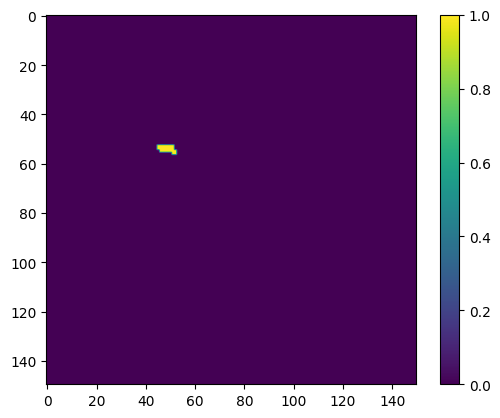

In [414]:
plt.imshow(model.instance_distributions[-1][0][6].cpu(), vmin=0, vmax=1);
plt.colorbar();

In [398]:
model.instance_distributions[-1][0].shape

torch.Size([11, 150, 150])

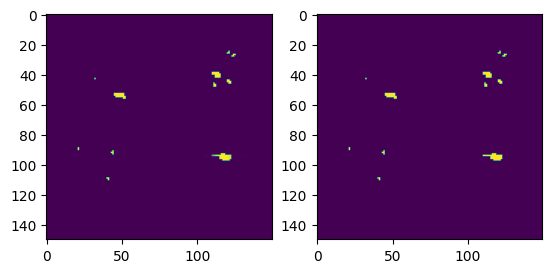

In [399]:
plt.subplot(1,2,1)
instances = torch.stack([inst for inst in model.instance_distributions[-1][0]])
plt.imshow(instances.sum(dim=0), vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.imshow(example_label_instances[0][0] != 0)

In [400]:
instances.shape

torch.Size([11, 150, 150])

In [401]:
example_label_instances.shape

torch.Size([1, 1, 150, 150])

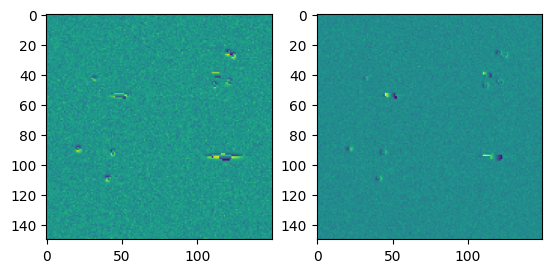

In [402]:
plt.subplot(1,2,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

#embedding = grid/150 + model.offset_vector_random.detach().tanh()
# embedding = grid + model.offset_vector_random.detach().cpu()
embedding = neven_loss.embedding_vectors(model.offset_vector_random.detach()).cpu()

# plt.imshow(embedding[0,1]); plt.colorbar()
# plt.imshow(model.log_2pres_squared_random[0,0].detach()); plt.colorbar()
# plt.imshow(model.seed_map_random[0,0].detach()); plt.colorbar()
plt.imshow(model.offset_vector_random.detach().cpu()[0,0]);# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(model.offset_vector_random.detach().cpu()[0,1]);# plt.colorbar()

In [405]:
points_random = embedding.reshape((3, -1))

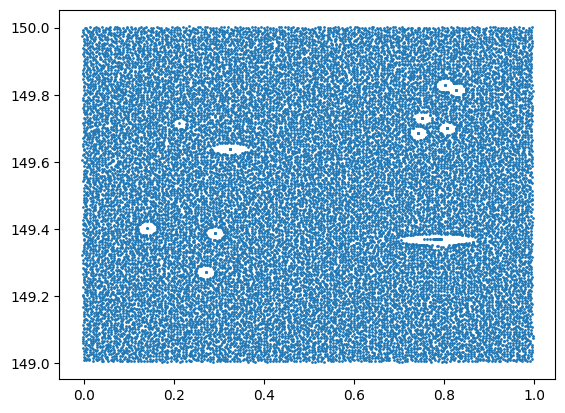

In [410]:
plt.scatter(points_random[1], 150-points_random[0], s=1)

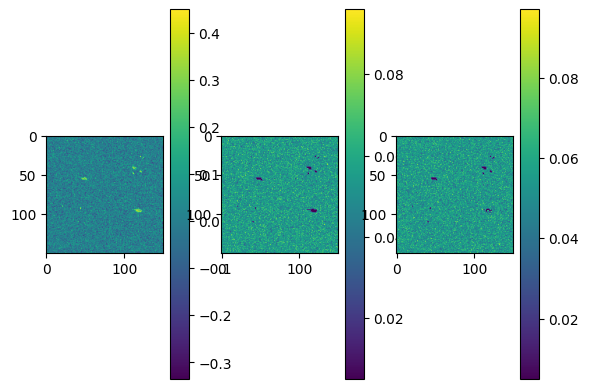

In [411]:
plt.subplot(1,3,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

sigma_random = activ(model.sigma_map_random)
plt.imshow(model.seed_map_random[0,0].detach().cpu()); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(sigma_random[0,0].detach().cpu()); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(sigma_random[0,1].detach().cpu()); plt.colorbar()

### list of what is working or needs checking

- [x] trains with fixed centre and full scale vectors
- [x] trains with learned centre and full scale vectors (yes works even better)
- [ ] scaling down the vectors, does it still train?
- [ ] finding a suitable way to constrain log2pres does it train?